Synchronize DLC results with xr_session

In [1]:
%reload_ext autoreload
%autoreload 2
from trialexp.process.deeplabcut import utils as dlc_utils
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import Video
import seaborn as sns
from trialexp.process.pyphotometry.utils import make_event_xr, extract_event_data
from moviepy.editor import *


In [2]:
fn = '06-14-23_14-40-49.000_TT002_Rig_3_Side_recode'
session_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-14-144112/'
videofile = session_path +f'video/{fn}.mp4'

# Load DLC results

In [3]:
dftip = pd.read_pickle('dftip.pkl')
dfwrist = pd.read_pickle('dfwrist.pkl')

In [4]:
dftip = dlc_utils.add_video_timestamp(dftip, videofile)
dfwrist = dlc_utils.add_video_timestamp(dfwrist, videofile)    

In [5]:
xr_dlc = xr.DataArray([dfwrist,dftip], dims=('marker','time','coords'),
                 coords={'marker':['wrist','tip'],
                         'time':dfwrist.index,
                         'coords':['x','y','likelihood']
                 })

## Synchronize with the xr_session

In [6]:
xr_session = xr.open_dataset(session_path+'/processed/xr_session.nc')

# resample to the xr_session time
xr_dlc = xr_dlc.interp(time=xr_session.time)
xr_session['dlc_markers'] = xr_dlc

In [7]:
xr_session.to_netcdf('xr_session_dlc.nc', engine='h5netcdf')

In [8]:
wrist_loc = xr_session['dlc_markers'].loc['wrist',:,['x','y']]
tip_loc = xr_session['dlc_markers'].loc['tip',:,['x','y']]

## Analyze movement data

In [9]:
signal_time, coords, speed, accel = dlc_utils.get_movement_metrics(wrist_loc)
speed_mag = np.linalg.norm(speed,axis=1)
accel_mag = np.diff(speed_mag, prepend=speed_mag[0])

**Direction of axis in image:**

- x: increase from left to right
- y: increase from top to bottom
- speed_x: -ve : left
- speed_y: -ve : up

In [10]:
f = xr_session.zscored_df_over_f.data[0]

df_move = pd.DataFrame({
    'accel': accel_mag,
    'accel_x': accel[:,0],
    'accel_y': accel[:,1],
    'speed': speed_mag,
    'speed_x': speed[:,0],
    'speed_y': speed[:,1],
    'x' : coords[:,0],
    'y' : coords[:,1],
    'time': xr_session.time,
    'df/f': f})
df_move

,accel,accel_x,accel_y,speed,speed_x,speed_y,x,y,time,df/f
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,866.019236,718.237255,7608.5,0.205254
1,0.057733,0.014156,-0.055971,0.057733,0.014156,-0.055971,866.033392,718.181284,7618.5,0.292358
2,-0.014141,0.028642,0.047690,0.043592,0.042798,-0.008280,866.076190,718.173004,7628.5,0.262030
3,0.027108,0.027034,-0.002757,0.070699,0.069833,-0.011037,866.146023,718.161967,7638.5,0.201862
4,0.015841,0.012326,-0.016152,0.086541,0.082158,-0.027190,866.228181,718.134777,7648.5,0.231352
...,...,...,...,...,...,...,...,...,...,...
176423,0.047227,-1.242300,0.265860,0.658829,-0.644407,0.137092,870.201456,747.134276,1771827.5,0.003056
176424,2.613453,-2.555329,0.548121,3.272282,-3.199736,0.685213,867.001720,747.819489,1771837.5,0.031638
176425,1.856771,-1.815902,0.387428,5.129054,-5.015639,1.072641,861.986081,748.892130,1771847.5,0.086082
176426,-0.771006,0.751912,-0.170858,4.358047,-4.263727,0.901783,857.722354,749.793913,1771857.5,0.064148


## Study movement initation

all init: 6511 valid init : 180


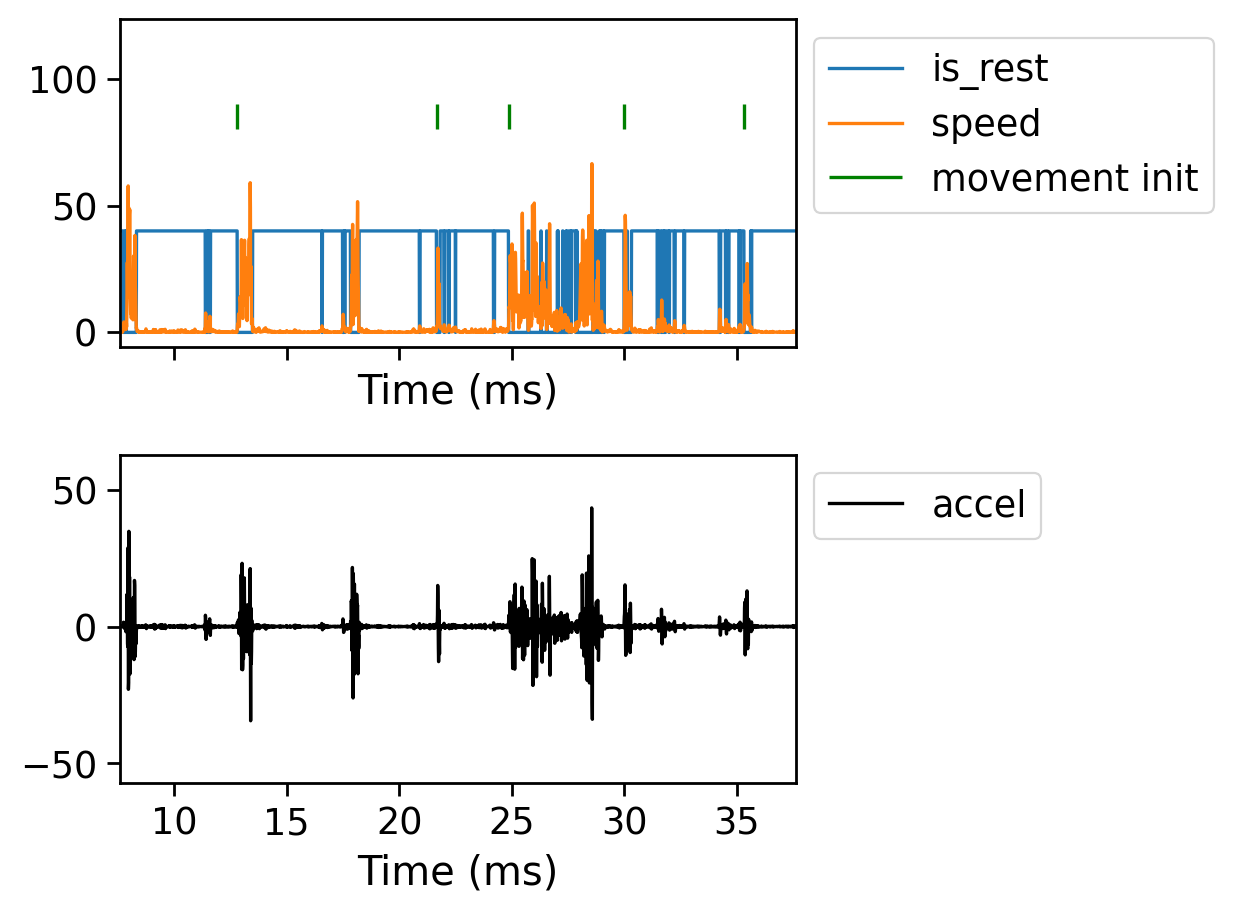

In [11]:
sns.set_context('paper', font_scale=1.5)

df2plot = df_move
time = df_move.time/1000

is_moving = (df2plot.speed>5)
is_rest = ((df2plot.speed<2) & (df2plot.accel.abs()<3)).astype(np.int8)
df_move['is_rest'] = is_rest

fig,ax = plt.subplots(2,1,sharex=True, dpi=200)


ax[0].plot(time, is_rest*40, label='is_rest')
ax[0].plot(time, df2plot.speed, label='speed')

ax[1].plot(time, df2plot.accel, label='accel',color='k')
ax[1].set_xlabel('Time (ms)')
ax[1].legend(bbox_to_anchor=[1,1], loc='upper left')

move_init_idx = np.where(np.diff(is_rest, prepend=False)==-1)[0]
# ax[0].eventplot(move_init_idx, lineoffsets = 65, linelength=10)

move_init_time = df_move.iloc[move_init_idx].time
ax[0].set_xlim([time[0],time[0]+30])


def filter_init(df_move, move_init_idx, consec_rest, consec_move):
    # filter move init only if it is proceed by some amount of consec_rest
    # followed by consec_move of movement
    # allow for some tolerance as there may be tracking error
    
    valid_init = []
    for idx in move_init_idx:
        rest_cond = df_move.iloc[(idx-consec_rest):idx].is_rest.mean() > 0.9
        move_cond = df_move.iloc[idx:(idx+consec_move)].is_rest.mean() < 0.1
        if (rest_cond and move_cond):
            valid_init.append(idx)
            
    return valid_init

valid_init = filter_init(df_move, move_init_idx,50, 10)
valid_init_time = df_move.iloc[valid_init].time

ax[0].eventplot(time[valid_init], lineoffsets = 85, linelength=10, color='g', label='movement init')
ax[0].set_xlabel('Time (ms)')
ax[0].legend(bbox_to_anchor=[1,1], loc='upper left')

fig.tight_layout()

fig.savefig('move_init.png',dpi=200, bbox_inches='tight')

print(f'all init: {len(move_init_idx)} valid init : {len(valid_init)}')

Extracted 179 events


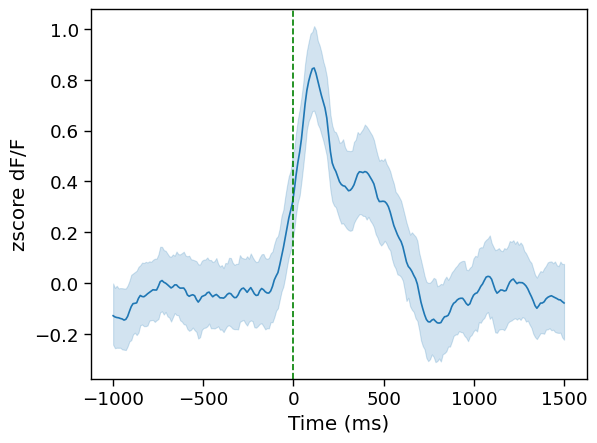

In [13]:
# xr_sessoin is at 100Hz

df_init = dlc_utils.extract_triggered_data(valid_init_time, xr_session, [-1000, 1500],
                                             sampling_rate=100)
ax = sns.lineplot(df_init, x='event_time', y='photometry')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('zscore dF/F')
ax.axvline(0,ls='--',color='g')
plt.savefig('photom_move_init.png',dpi=200)

In [14]:
dlc_utils.extract_sample_video_multi(videofile, 'move_int', 
                                     valid_init_time[:5].values, video_type='gif', resize_ratio=0.5)

Saved sample_video/move_int_24
Saved sample_video/move_int_29
Saved sample_video/move_int_12
Saved sample_video/move_int_21
Saved sample_video/move_int_35


### Separate into forward and backward movement

In [22]:
direction = dlc_utils.get_direction(df_move, valid_init)
speed = dlc_utils.get_average_speed(df_move, valid_init)
accel = dlc_utils.get_average_value(df_move,'accel', valid_init)
x = dlc_utils.get_average_value(df_move,'x', valid_init, win_dir='before')
y = dlc_utils.get_average_value(df_move,'y', valid_init, win_dir='before')

mov_type = dlc_utils.get_movement_type(df_move, valid_init, 100, window=50)
speed_cls = pd.qcut(speed,3, labels=['slow','middle','fast'])
average_photom = dlc_utils.get_average_photom(df_move, valid_init)

df_init_time =  pd.DataFrame({'event_index':np.arange(len(direction)), 
                              'init_time': valid_init_time,
                              'speed': speed,
                              'x': x,
                              'y': y,
                              'accel': accel,
                              'speed_class': speed_cls,
                              'move_type': mov_type,
                              'df/f': average_photom,
                              'direction':direction})

df_init_time.to_pickle('df_init_time.pkl')
# display(df_init_time)
display(df_init_time.groupby(['direction','move_type']).count())
df_init2 = df_init.merge(df_init_time, on='event_index')
df_init2

event_index  init_time  speed   x   y  accel  \
direction move_type                                                 
backward  reach               32         32     32  32  32     32   
          twitch              31         31     31  31  31     31   
forward   reach               18         18     18  18  18     18   
          twitch              99         99     99  99  99     99   

                     speed_class  df/f  
direction move_type                     
backward  reach               32    32  
          twitch              31    31  
forward   reach               18    18  
          twitch              99    99

,event_index,event_time,photometry,init_time,speed,x,y,accel,speed_class,move_type,df/f,direction
0,0,-1000.000000,-0.061872,12808.5,4.022312,884.245993,741.749512,0.128883,slow,reach,-0.993206,forward
1,0,-989.959839,0.020588,12808.5,4.022312,884.245993,741.749512,0.128883,slow,reach,-0.993206,forward
2,0,-979.919679,-0.008874,12808.5,4.022312,884.245993,741.749512,0.128883,slow,reach,-0.993206,forward
3,0,-969.879518,-0.077045,12808.5,4.022312,884.245993,741.749512,0.128883,slow,reach,-0.993206,forward
4,0,-959.839357,-0.294679,12808.5,4.022312,884.245993,741.749512,0.128883,slow,reach,-0.993206,forward
...,...,...,...,...,...,...,...,...,...,...,...,...
44995,179,1459.839357,NaN,1770477.5,23.477346,617.385534,743.309963,0.608716,fast,reach,-0.105796,backward
44996,179,1469.879518,NaN,1770477.5,23.477346,617.385534,743.309963,0.608716,fast,reach,-0.105796,backward
44997,179,1479.919679,NaN,1770477.5,23.477346,617.385534,743.309963,0.608716,fast,reach,-0.105796,backward
44998,179,1489.959839,NaN,1770477.5,23.477346,617.385534,743.309963,0.608716,fast,reach,-0.105796,backward


,event_time,photometry,init_time,speed,speed_class,move_type
direction,,,,,,
backward,40,39,40,40,40,40
forward,80,80,80,80,80,80


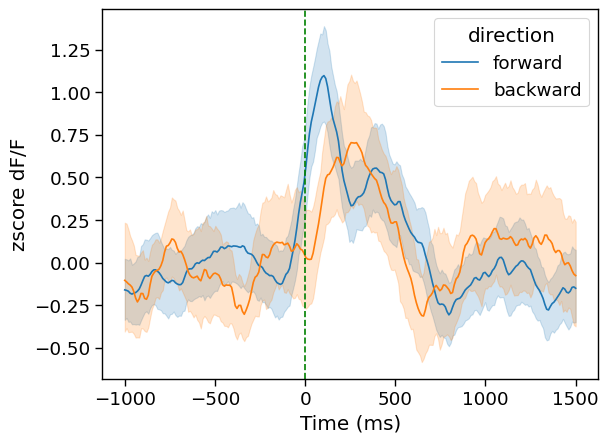

In [304]:
df2plot = df_init2[df_init2.speed>10]
display(df2plot.groupby(['event_index']).first().groupby('direction').count())

ax = sns.lineplot(df2plot, x='event_time', y='photometry', hue='direction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('zscore dF/F')
ax.axvline(0,ls='--',color='g')
plt.savefig('photom_movement_direction.png',dpi=200)

In [244]:
forward_time = df_init_time.query("direction=='forward' and speed_class!= 'slow'").init_time.values
backward_time = df_init_time.query("direction=='backward' and speed_class!= 'slow'").init_time.values

dlc_utils.extract_sample_video_multi(videofile, 'move_int_forward', 
                                     forward_time[:5], video_type='gif', resize_ratio=0.4)

dlc_utils.extract_sample_video_multi(videofile, 'move_int_backward', 
                                     backward_time[:5], video_type='gif', resize_ratio=0.4)

Saved sample_video/move_int_forward_24
Saved sample_video/move_int_forward_21
Saved sample_video/move_int_forward_61
Saved sample_video/move_int_forward_35
Saved sample_video/move_int_forward_45
Saved sample_video/move_int_backward_29
Saved sample_video/move_int_backward_273
Saved sample_video/move_int_backward_252
Saved sample_video/move_int_backward_337
Saved sample_video/move_int_backward_310


### Movement speed

,event_time,photometry,init_time,speed,speed_class,move_type
direction,,,,,,
backward,32,31,32,32,32,32
forward,18,18,18,18,18,18


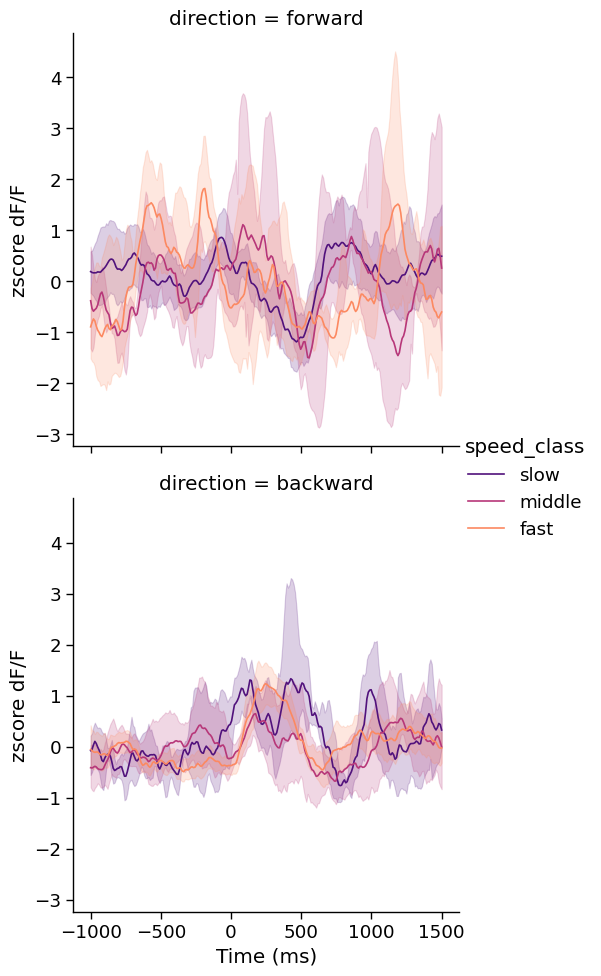

In [306]:
df2plot = df_init2[df_init2.move_type=='reach']
display(df2plot.groupby(['event_index']).first().groupby('direction').count())

g = sns.relplot(df2plot, kind='line', x='event_time',
                y='photometry', row='direction', hue='speed_class', palette='magma')
g.set_xlabels('Time (ms)')
g.set_ylabels('zscore dF/F')
plt.savefig('photom_movement_speed.png',dpi=200)

In [273]:
df_speed_class = df_init_time.groupby(['speed_class','direction']).first().reset_index()
df_speed_class

for _, row in df_speed_class.iterrows():
    dlc_utils.extract_sample_video_multi(videofile, f'{row.direction}_{row.speed_class}', 
                                     [row.init_time], video_type='gif', resize_ratio=0.4)

Saved sample_video/backward_slow_42
Saved sample_video/forward_slow_12
Saved sample_video/backward_middle_337
Saved sample_video/forward_middle_21
Saved sample_video/backward_fast_29
Saved sample_video/forward_fast_24


## Movement type

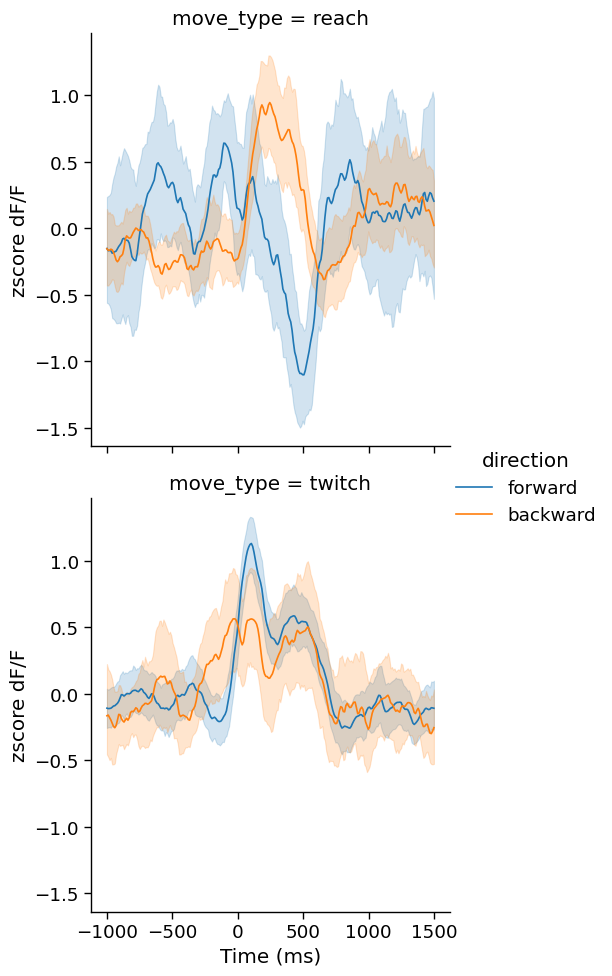

In [299]:
df2plot = df_init2

g = sns.relplot(df2plot, kind='line', x='event_time',
                y='photometry', hue='direction', row='move_type')
g.set_xlabels('Time (ms)')
g.set_ylabels('zscore dF/F')
plt.savefig('photom_movement_type.png',dpi=200)

In [291]:
df_speed_class = df_init_time.groupby(['move_type','direction']).first().reset_index()
df_speed_class

for _, row in df_speed_class.iterrows():
    dlc_utils.extract_sample_video_multi(videofile, f'{row.direction}_{row.move_type}', 
                                     [row.init_time], video_type='gif', resize_ratio=0.4)

Saved sample_video/backward_reach_29
Saved sample_video/forward_reach_12
Saved sample_video/backward_twist_42
Saved sample_video/forward_twist_21


 Things to study
 - Forward aceleration and backward acceleration
 - acceleraton and deceleration

## Speed and photom

<Axes: xlabel='speed', ylabel='df/f'>

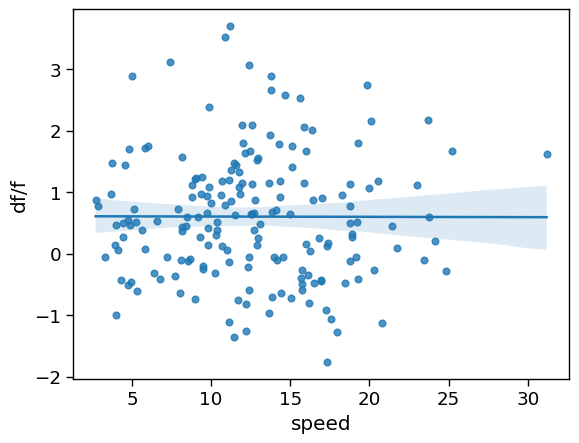

In [318]:
sns.regplot(df_init_time, x='speed', y='df/f')

## TODO
- Segregate based on position

AttributeError: module 'matplotlib.pylab' has no attribute 'adjust_subplots'

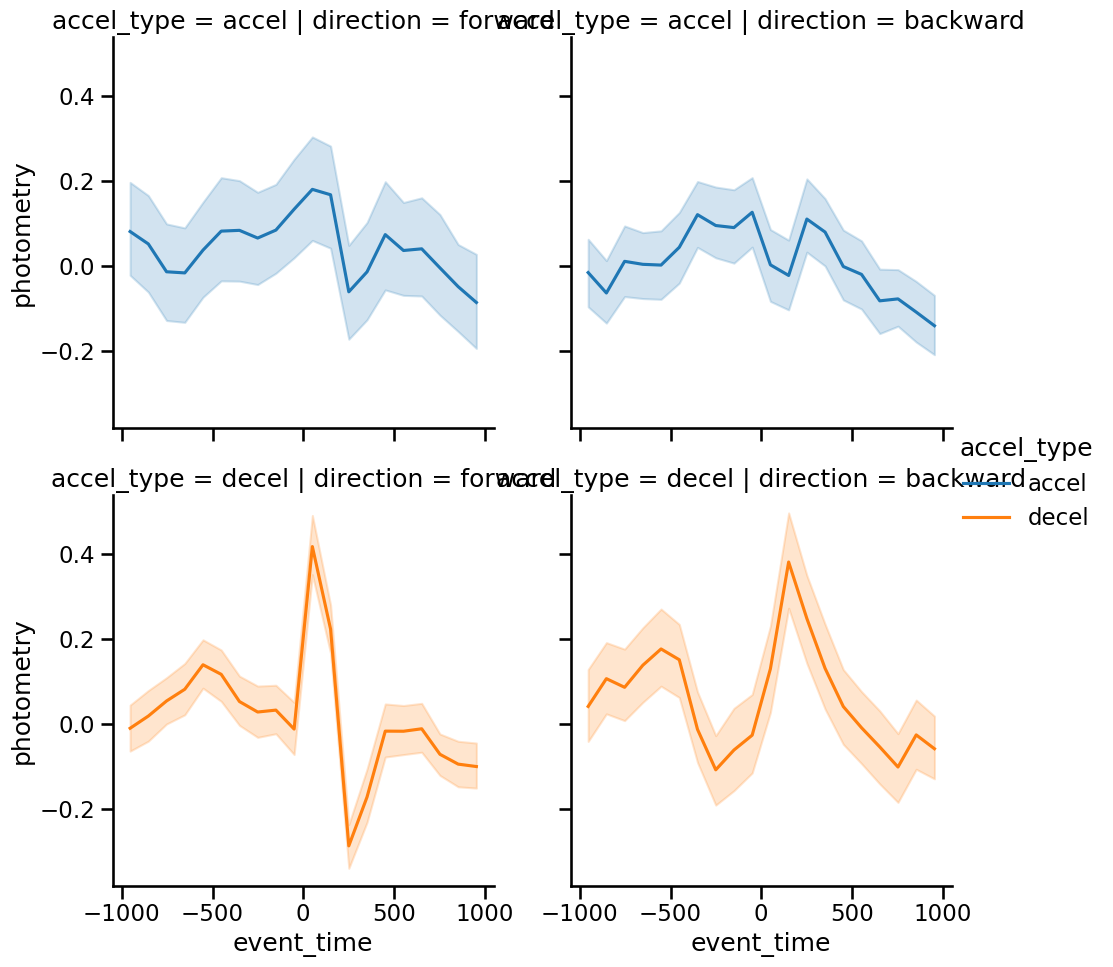

In [ ]:
sns.set_context('talk')
sns.relplot(df2plot, kind='line', x='event_time', y='photometry', hue='accel_type', 
            row='accel_type', col='direction')
plt.adjust_subplots(wspace=0.2)

## Distribution analysis

<Axes: xlabel='accel', ylabel='df/f'>

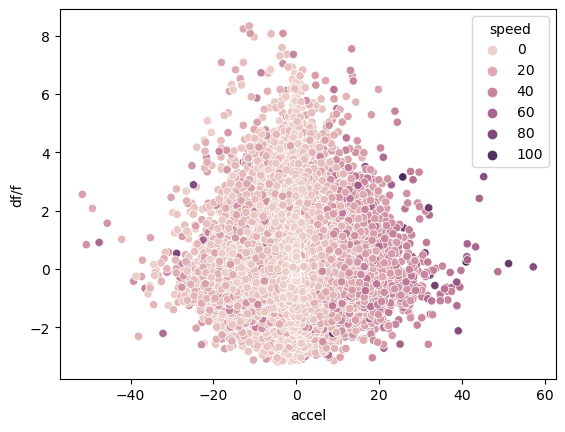

In [12]:
sns.scatterplot(df_vigor, x='accel', y='df/f', hue='speed')

<Axes: xlabel='speed', ylabel='df/f'>

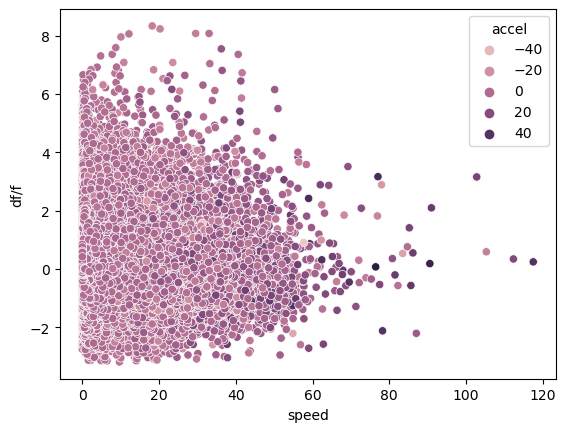

In [13]:
sns.scatterplot(df_vigor, x='speed', y='df/f', hue='accel')